In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scanpy as sc,anndata as ad
import squidpy as sq
import os
import re
import sys
from scipy.sparse import vstack
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,scale
from scipy.spatial import distance_matrix, distance
from sklearn.neighbors import KernelDensity
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sklearn.neighbors import BallTree
import time
import rdata
from scipy.sparse import csr_matrix,bsr_matrix,coo_matrix,issparse,lil_matrix,diags
from scipy.sparse.linalg import inv
import scipy as sp
from  scipy.ndimage import gaussian_filter
import igraph as ig
import glasbey
import warnings
import cairocffi as cairo
from sklearn.metrics import adjusted_rand_score,make_scorer
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn import preprocessing
import libpysal
from esda.losh import LOSH
from multiprocessing import Pool
from mclustpy import mclustpy
from sklearn.cluster import KMeans
import torch
#from GraphST import GraphST
import SEDR
#from GraphST.utils import clustering
from matplotlib.colors import ListedColormap
from esda import Moran
from libpysal.weights import KNN
from scsampler import scsampler 
from geosketch import gs
from scvalue import SCValue
from tqdm import tqdm
from fbpca import pca
from annoy import AnnoyIndex
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm


class RASP:
    @staticmethod
    def build_weights_matrix(adata, n_neighbors=6, beta=2, platform='visium'):
        """
        Build a sparse distance matrix including only the K nearest neighbors, and compute inverse weighting.

        Parameters:
        - adata: Annotated data object.
        - n_neighbors: int - number of nearest neighbors to include.
        - beta: weight exponent parameter.
        - platform: string - type of platform.

        Returns:
        - sparse_distance_matrix: csr_matrix - sparse distance matrix of shape (n_samples, n_samples).
        """
        coords = adata.obsm['spatial']
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(coords)
        distances, indices = nbrs.kneighbors(coords)

        # Build the sparse matrix
        data = distances.flatten()
        row_indices = np.repeat(np.arange(coords.shape[0]), n_neighbors)
        col_indices = indices.flatten()
        sparse_distance_matrix = coo_matrix((data, (row_indices, col_indices)), shape=(coords.shape[0], coords.shape[0])).tocsr()

        # Remove outliers
        temp_matrix = sparse_distance_matrix.tocoo()
        percentile_99 = np.percentile(temp_matrix.data, 99)
        temp_matrix.data[temp_matrix.data > percentile_99] = 0
        sparse_distance_matrix = temp_matrix.tocsr()

        # Invert and exponentiate non-zero values
        non_zero_values = sparse_distance_matrix.data[sparse_distance_matrix.data > 0]
        min_non_zero_value = np.min(non_zero_values) if non_zero_values.size > 0 else 1

        if platform == 'visium':
            sparse_distance_matrix.setdiag(min_non_zero_value / 2)
        else:
            sparse_distance_matrix.setdiag(min_non_zero_value)

        inverse_sq_data = np.zeros_like(sparse_distance_matrix.data)
        inverse_sq_data[sparse_distance_matrix.data > 0] = 1 / (sparse_distance_matrix.data[sparse_distance_matrix.data > 0] ** beta)

        inverse_sq_matrix = csr_matrix((inverse_sq_data, sparse_distance_matrix.indices, sparse_distance_matrix.indptr),
                                        shape=sparse_distance_matrix.shape)

        row_sums = inverse_sq_matrix.sum(axis=1).A1
        row_sums[row_sums == 0] = 1
        weights = inverse_sq_matrix.multiply(1 / row_sums[:, np.newaxis])

        return weights

    @staticmethod
    def clustering(adata, n_clusters=7, n_neighbors=10, key='X_pca_smoothed', method='mclust'):
        """
        Spatial clustering.

        Parameters:
        - adata: AnnData object of scanpy package.
        - n_clusters: int, optional - The number of clusters. Default is 7.
        - n_neighbors: int, optional - The number of neighbors considered during refinement. Default is 15.
        - key: string, optional - The key of the learned representation in adata.obsm. Default is 'X_pca_smoothed'.
        - method: string, optional - The tool for clustering. Supported tools: 'mclust', 'leiden', 'louvain'.

        Returns:
        - adata: Updated AnnData object with clustering results.
        """

        if method == 'mclust':
            np.random.seed(2020)
            import rpy2.robjects as robjects
            robjects.r.library("mclust")
            import rpy2.robjects.numpy2ri
            rpy2.robjects.numpy2ri.activate()
            r_random_seed = robjects.r['set.seed']
            r_random_seed(2020)
            rmclust = robjects.r['Mclust']
            res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[key]), n_clusters, 'EEE')
            mclust_res = np.array(res[-2])
            adata.obs[f'RASP_{method}_clusters'] = mclust_res
            adata.obs[f'RASP_{method}_clusters'] = adata.obs[f'RASP_{method}_clusters'].astype('int')
            adata.obs[f'RASP_{method}_clusters'] = adata.obs[f'RASP_{method}_clusters'].astype('category')

        elif method == 'louvain':
            adata = RASP.louvain(adata, n_clusters, n_neighbors=n_neighbors, key_added='RASP_louvain_clusters')

        elif method == 'leiden':
            adata = RASP.leiden(adata, n_clusters, n_neighbors=n_neighbors, key_added='RASP_leiden_clusters')

        elif method =="walktrap":
                neighbors_graph = adata.obsp['connectivities']
                sources, targets = neighbors_graph.nonzero()
                weights = neighbors_graph[sources, targets].A1
                g = ig.Graph(directed=False)
                g.add_vertices(adata.n_obs)
                g.add_edges(zip(sources, targets))
                g.es['weight'] = weights
            
                # Perform Walktrap community detection
                start_time = time.time()
                walktrap = g.community_walktrap(weights='weight')
                clusters = walktrap.as_clustering(n=n_clusters)
                end_time = time.time()
                cluster_time = end_time - start_time
                adata.obs[f'RASP_{method}_clusters'] = pd.Categorical(clusters.membership)

        elif method == "KMeans":
            kmeans = KMeans(n_clusters = n_clusters,random_state = 10)
            adata.obs[f'RASP_{method}_clusters'] = pd.Categorical(kmeans.fit_predict(adata.obsm['X_pca_smoothed']))

        num_clusters = len(set(adata.obs[f'RASP_{method}_clusters']))
        palette = glasbey.create_palette(palette_size=num_clusters)
        adata.uns[f'RASP_{method}_clusters_colors'] = palette

        return adata

    @staticmethod
    def louvain(adata,n_clusters,n_neighbors = 10,use_rep = 'X_pca_smoothed',key_added = 'RASP_louvain_clusters',random_seed = 2023):
        res = RASP.res_search_fixed_clus_louvain(adata, n_clusters, increment=0.1, start = 0.001,random_seed=random_seed)
        print(f'resolution is: {res}')
        sc.tl.louvain(adata, random_state=random_seed, resolution=res)
       
        adata.obs[key_added] = adata.obs['louvain']
        adata.obs[key_added] = adata.obs[key_added].astype('int')
        adata.obs[key_added] = adata.obs[key_added].astype('category')

        return adata

    @staticmethod
    def leiden(adata,n_clusters,n_neighbors = 10,use_rep = 'X_pca_smoothed',key_added = 'RASP_leiden_clusters',random_seed = 2023):
        res = RASP.res_search_fixed_clus_leiden(adata, n_clusters, increment=0.1, start = 0.001,random_seed=random_seed)
        print(f'resolution is: {res}')
        sc.tl.leiden(adata, random_state=random_seed, resolution=res)
       
        adata.obs[key_added] = adata.obs['leiden']
        adata.obs[key_added] = adata.obs[key_added].astype('int')
        adata.obs[key_added] = adata.obs[key_added].astype('category')

        return adata

    @staticmethod
    def res_search_fixed_clus_louvain(adata, n_clusters, increment=0.1, start=0.001, random_seed=2023):
        """
        Search for the correct resolution for the Louvain clustering algorithm.

        Parameters:
        - adata: AnnData object containing the data.
        - n_clusters: int - The target number of clusters.
        - increment: float, optional - The step size for resolution search (default is 0.1).
        - start: float, optional - The starting resolution for the search (default is 0.001).
        - random_seed: int, optional - Random seed for reproducibility (default is 2023).

        Returns:
        - float: The largest correct resolution found for the specified number of clusters.
        """
        if increment < 0.0001:
            print("Increment too small, returning starting value.")
            return start  # Return the initial start value
        #keep track of the currect resolution and the largest resolution that is not to large. 
        largest_correct_res = None
        current_res = start
        for res in np.arange(start,2,increment):
            sc.tl.louvain(adata,random_state = random_seed,resolution = res)
            
            #increase res tracker to current res
            current_res = res

            
            num_clusters = len(adata.obs['louvain'].unique())
            print(f'Resolution: {res} gives cluster number: {num_clusters}')

            if num_clusters == n_clusters:
                largest_correct_res = res  # Update the largest correct resolution found
            
            #Check to see if the res resulted in too many clusters! 
            #break out of loop if we exceed this point. 
            if num_clusters > n_clusters:
                break

        
        #return correct res if you have one! 
        if largest_correct_res is not None:
            return largest_correct_res

        #perform tail end recursion until correct res is found! 
        else:
            return RASP.res_search_fixed_clus_louvain(
                adata,
                n_clusters,
                increment = increment/10,
                start = current_res - increment,
                random_seed = random_seed)


    @staticmethod
    def res_search_fixed_clus_leiden(adata, n_clusters, increment=0.1, start=0.001, random_seed=2023):
        """
        Search for the correct resolution for the Leiden clustering algorithm.

        Parameters:
        - adata: AnnData object containing the data.
        - n_clusters: int - The target number of clusters.
        - increment: float, optional - The step size for resolution search (default is 0.1).
        - start: float, optional - The starting resolution for the search (default is 0.001).
        - random_seed: int, optional - Random seed for reproducibility (default is 2023).

        Returns:
        - float: The largest correct resolution found for the specified number of clusters.
        """
        if increment < 0.0001:
            print("Increment too small, returning starting value.")
            return start  # Return the initial start value
        #keep track of the currect resolution and the largest resolution that is not to large. 
        largest_correct_res = None
        current_res = start
        for res in np.arange(start,2,increment):
            sc.tl.leiden(adata,random_state = random_seed,resolution = res)
            
            #increase res tracker to current res
            current_res = res

            
            num_clusters = len(adata.obs['leiden'].unique())
            print(f'Resolution: {res} gives cluster number: {num_clusters}')

            if num_clusters == n_clusters:
                largest_correct_res = res  # Update the largest correct resolution found
            
            #now check to see if the res resulted in too many clusters! 
            #break out of loop if we exceed this point. 
            if num_clusters > n_clusters:
                break

        
        #return correct res if you have one! 
        if largest_correct_res is not None:
            return largest_correct_res

        #perform tail end recursion until correct res is found! 
        else:
            return RASP.res_search_fixed_clus_leiden(
                adata,
                n_clusters,
                increment = increment/10,
                start = current_res - increment,
                random_seed = random_seed)
    
    
   

    

    @staticmethod
    def fx_1NN(index, location_in):
        """
        Python equivalent of the fx_1NN function that is called in the loop.
        Computes the distance from the point at 'index' to its nearest neighbor.
        """
        distances = cdist([location_in[index]], location_in, 'euclidean')
        nearest_neighbor = np.partition(distances, 1)[0, 1]  # 1st closest distance
        return nearest_neighbor
    @staticmethod
    def CHAOS(clusterlabel, location):
        matched_location = np.array(location)
        clusterlabel = np.array(clusterlabel)
        
        # Remove NA (None) values
        NAs = np.where(pd.isna(clusterlabel))[0]
        if len(NAs) > 0:
            clusterlabel = np.delete(clusterlabel, NAs)
            matched_location = np.delete(matched_location, NAs, axis=0)
    
        # Standardize the location data
        matched_location = scale(matched_location)
    
        unique_labels = np.unique(clusterlabel)
        dist_val = np.zeros(len(unique_labels))
        
        for count, k in enumerate(unique_labels):
            location_cluster = matched_location[clusterlabel == k]
            if location_cluster.shape[0] == 1:  # Only one point in cluster
                continue
    
            with Pool(5) as pool:  # Parallel processing with 5 cores
                results = pool.starmap(RASP.fx_1NN, [(i, location_cluster) for i in range(location_cluster.shape[0])])
            
            dist_val[count] = sum(results)
        
        dist_val = dist_val[~np.isnan(dist_val)]  # Remove any NaN values
        return np.sum(dist_val) / len(clusterlabel)


    @staticmethod
    def reconstruct_gene(adata, 
                                smoothed_pca_matrix, 
                                weights,
                                gene_name='test', 
                                quantile_prob=0.001,
                                scale = False,
                                threshold_method = 'ALRA',
                                rank_k = 20):

 
        """
        Restore true biological zeros while considering excess zeros and apply scaling.
        
        Parameters:
        - adata: AnnData object containing the gene expression data.
        - smoothed_pca_one: PCA smoothed data after initial PCA.
        - smoothed_pca_two: PCA smoothed data after adding features.
        - pca_weights_initial: Weights from the initial PCA.
        - pca_weights_final: Weights from the final PCA (optional).
        - gene_name: The specific gene for which to restore zeros.
        - quantile_prob: The quantile threshold to use for determining biological zeros.
        - plot_hist: Bool indicator to output the histogram of the gene expression before and after reconstruction
        - scale: Bool indicator to scale values to match original expression
        - threshold_method: ALRA or Zero, how to deal with restoration of biological zeros to the imputed data. 
        
        Returns:
        - adata: Updated AnnData object with reconstructed zeros.
        """
        
        # Get the original gene expression data
        original_data = adata.X
        indices = range(rank_k)
        gene_index = adata.var.index.get_loc(gene_name)
        original_expression = original_data[:, gene_index].toarray().flatten() if isinstance(original_data, csr_matrix) else original_data[:, gene_index]
    
        
    
            #subset to get rank k reconstruction: 
        indices = range(rank_k)
        smoothed_pca_matrix = smoothed_pca_matrix[:,indices]
    
        gene_weights = weights[indices, gene_index]
        reconstructed_gene_expression = np.dot(smoothed_pca_matrix, gene_weights)
    
        delta_mean = np.mean(original_expression)
        reconstructed_gene_expression += delta_mean
    
        # Calculate the quantile threshold using absolute value
        #note: the ALRA method uses the abs of the quantile and then restores the expression of some cell cells that are non-zero 
        # from the original expression matrix. This is different than what I am doing which is taking whatever is smaller: the threshold or 
        # zero. 
    
    
        if threshold_method == 'Zero':
            threshold_value = np.quantile(reconstructed_gene_expression, quantile_prob)
            threshold_value = max(0,threshold_value)
        
            print(f'Threshold read value: {np.quantile(reconstructed_gene_expression, quantile_prob)}')
            
            
            # Restore the biological zeros based on the excess zeros logic
            restored_expression = reconstructed_gene_expression.copy()
            print(f'Number of cells below the threshold: {np.sum(restored_expression < threshold_value)}')
            print(f'Number of cells below zero: {np.sum(restored_expression < 0)}')
        
            restored_expression[restored_expression < threshold_value] = 0
    
            
        
            #in case negative values remain, set those to zero as well! 
            #restored_expression[restored_expression < 0] = 0 
        
            print(f'Number of cells with zero before imputation:{np.sum(original_expression==0)}')
            print(f'Number of cells with zero AFTER imputation:{np.sum(restored_expression==0)}')
    
        if threshold_method == 'ALRA':
            threshold_value =  np.abs(np.quantile(reconstructed_gene_expression, quantile_prob))
            print(f'Threshold (absolute value for ALRA method): {threshold_value}')
            restored_expression = reconstructed_gene_expression.copy()
            print(f'Number of cells below the threshold: {np.sum(restored_expression < threshold_value)}')
            print(f'Number of cells below zero: {np.sum(restored_expression < 0)}')
            restored_expression[restored_expression < threshold_value] = 0
            
            # Restore original values for Non-Zero entries that were thresholded out
            mask_thresholded_to_zero = (reconstructed_gene_expression < threshold_value) & (original_expression > 0)
    
            #note: the ALRA method restors the original expression here. What I am doing is instead restoring the 
            #reconstructed expression, as long as it is not zero! 
            #restored_expression[mask_thresholded_to_zero] = original_expression[mask_thresholded_to_zero]
            restored_expression[mask_thresholded_to_zero] = reconstructed_gene_expression[mask_thresholded_to_zero]
            print(f'Number of cells restored to original values:{np.sum(mask_thresholded_to_zero != 0)}')
            print(f'Number of cells that where negative: {np.sum(reconstructed_gene_expression[mask_thresholded_to_zero]<0)}')
    
            #finally, set anything that is still negative to zero, should be a very small number of cells! 
            restored_expression[restored_expression < 0] = 0
            
        if scale:
            
    
            # Now, perform scaling based on the original and restored values
            sigma_1 = np.std(restored_expression[restored_expression > 0])
            sigma_2 = np.std(original_expression[original_expression > 0])
            mu_1 = np.mean(restored_expression[restored_expression > 0])
            mu_2 = np.mean(original_expression[original_expression > 0])
        
            # Avoid division by zero
            if sigma_1 == 0:
                sigma_1 = 1e-10  # Or choose to keep restored_expression intact
            
            # Determine scaling factors
            scaling_factor = sigma_2 / sigma_1
            offset = mu_2 - (mu_1 * scaling_factor)
        
            # Apply scaling
            restored_expression = restored_expression * scaling_factor + offset
        
            # If case scaling results in any negative values, turn those to zero as well! 
            #print(f'Number of cells turned negative after scaling: {np.sum(restored_expression_scaled < 0)}')
            restored_expression[restored_expression < 0] = 0
            
    
        # Store the final restored gene expression back into adata
        adata.obs['restored_' + gene_name] = restored_expression.flatten()
            
        return adata


#lets try the subsampling on a 
# need implimentation of Robust hausdorff distance computation 
from scipy.spatial.distance import directed_hausdorff
def partial_hausdorff_distance(array1, array2, q=1e-4):
    """
    Compute the partial Hausdorff distance from array1 to array2.
    
    Parameters:
    - array1: numpy.ndarray, shape (n, d)
        The first array of points (e.g., representing the full dataset).
    - array2: numpy.ndarray, shape (m, d)
        The second array of points (e.g., representing the subset).
    - q: float, optional
        The parameter for the partial Hausdorff distance, should be between 0 and 1.
        q=0 corresponds to the classical Hausdorff distance, q=1 would correspond to
        considering up to the smallest distance, practically ineffective in most uses.
    
    Returns:
    - float
        The partial Hausdorff distance based on q between array1 and array2.
    """
    
    # Calculate distances from each point in array1 to the nearest point in array2
    # distances = [directed_hausdorff([point], array2)[0] for point in tqdm(array1)]
    
    # # Sort the distances
    # distances.sort()
    
    # # Calculate the index for the Kth largest value
    # K = int(np.floor((1 - q) * len(distances)))
    
    # # Return the Kth largest value from the sorted distances
    # return distances[K-1] if K > 0 else distances[0]

    # Build KD-Tree for array2
    print("building KDTree")
    start = time.time()
    tree = KDTree(array2)
    end = time.time()
    print(f"KDTree took {end-start:.4f} seconds to build")
    # Query the tree with all points in array1 to find nearest neighbors efficiently
    print("query tree")
    start = time.time()
    distances, _ = tree.query(array1, k=1)
    end = time.time()
    print(f"distance calculation took: {end-start:.4f} seconds")

    # Sort all computed distances
    distances.sort()

    # Determine the index of the Kth largest value for partial Hausdorff
    K = int(np.floor((1 - q) * len(distances)))

    # Handle edge cases and return the Kth largest value
    return distances[K-1] if K > 0 else distances[0]


def partial_hausdorff_distance_annoy(array1, array2, q=1e-4, metric='euclidean', n_trees=10):
    """
    Compute the partial Hausdorff distance from array1 to array2 using Annoy for approximation.
    
    Parameters:
    - array1: numpy.ndarray, shape (n, d)
        The first array of points.
    - array2: numpy.ndarray, shape (m, d)
        The second array of points.
    - q: float, optional
        The parameter for the partial Hausdorff distance, should be between 0 and 1.
    - metric: string, optional
        The metric to use for distance calculations. Annoy supports 'euclidean' and 'angular'.
    - n_trees: int, optional
        Number of trees to use for Annoy's index construction.
    
    Returns:
    - float
        The estimated partial Hausdorff distance between array1 and array2.
    """
    # Build Annoy index for array2
    num_features = array2.shape[1]
    annoy_index = AnnoyIndex(num_features, metric)
    for i, vector in enumerate(array2):
        annoy_index.add_item(i, vector)
    print("building Annoy index")
    start = time.time()
    annoy_index.build(n_trees)
    end = time.time()
    print(f"Annoy index took {end-start:.4f} seconds to build")

    # Query for nearest neighbors
    print("finding nearest neighbors")
    start = time.time()
    distances = []
    for point in array1:
        nearest_idx, dist = annoy_index.get_nns_by_vector(point, 1, include_distances=True)
        distances.append(dist[0])
    end = time.time()
    print(f"ANN distance calculation took: {end-start:.4f} seconds")

    # Sort all computed distances
    distances.sort()
    # Determine the index of the Kth largest value for partial Hausdorff
    K = int(np.floor((1 - q) * len(distances)))
    # Handle edge cases and return the Kth largest value
    return distances[K-1] if K > 0 else distances[0]

def uniform_sample_adata(adata, fraction=0.1, random_state=None):
    """
    Uniformly samples a fraction of cells from an AnnData object.
    
    Parameters:
    - adata: AnnData object
    - fraction: float, fraction of cells to sample (default is 10%)
    - random_state: int, random seed for reproducibility (default is None)
    
    Returns:
    - AnnData object with sampled cells
    """
    print("running uniform sampling")
    np.random.seed(random_state)
    num_cells = adata.n_obs  # Total number of cells
    sample_size = int(num_cells * fraction)  # Compute number of cells to sample

    sampled_indices = np.random.choice(adata.obs.index, size=sample_size, replace=False)
    
    return adata[sampled_indices].copy()  # Return a new AnnData object

def probability_sample_adata(adata, fraction=0.1, score_column="gene_score", random_state=None):
    """
    Samples a fraction of cells from an AnnData object using weighted probabilities.

    Parameters:
    - adata: AnnData object
    - fraction: float, fraction of cells to sample (default is 10%)
    - score_column: str, column in adata.obs containing sampling probabilities
    - random_state: int, random seed for reproducibility (default is None)

    Returns:
    - AnnData object with sampled cells
    """
    print("running leverage sampling")
    np.random.seed(random_state)

    if score_column not in adata.obs:
        raise ValueError(f"Column '{score_column}' not found in adata.obs")

    scores = adata.obs[score_column].values
    # scores = np.clip(scores, a_min=0, a_max=None)  # Ensure no negative values
    probabilities = scores / scores.sum()  # Normalize to get probabilities

    num_cells = adata.n_obs
    sample_size = int(num_cells * fraction)

    sampled_indices = np.random.choice(adata.obs.index, size=sample_size, replace=False, p=probabilities)

    return adata[sampled_indices].copy()

def probability_sample_adata_efficient(adata, fraction=0.1, score_column="gene_score", random_state=None):
    """
    Efficiently samples a fraction of cells from an AnnData object using weighted probabilities.
    Parameters:
    - adata: AnnData object
    - fraction: float, fraction of cells to sample (default is 10%)
    - score_column: str, column in adata.obs containing sampling probabilities
    - random_state: int, random seed for reproducibility (default is None)
    Returns:
    - AnnData object with sampled cells
    """
    print("running efficient leverage sampling")
    np.random.seed(random_state)

    # Validate input and obtain scores
    if score_column not in adata.obs:
        raise ValueError(f"Column '{score_column}' not found in adata.obs")
    scores = adata.obs[score_column].values

    # Ensure non-negative scores and calculate probabilities
    scores = np.clip(scores, a_min=0, a_max=None)
    probabilities = scores / scores.sum()

    # Sample indices with weights using reservoir sampling
    num_cells = adata.n_obs
    sample_size = int(num_cells * fraction)
    sample_indices = []

    print("Start iterating over data")
    for i in range(num_cells):
        if len(sample_indices) < sample_size:
            sample_indices.append(i)
        else:
            j = np.random.randint(0, i + 1)
            if j < sample_size:
                sample_indices[j] = i
    print("get sample indices")
    sampled_indices = adata.obs.index[sample_indices]
    print("return object")
    return adata[sampled_indices].copy()

def evaluate_sampling_methods(adata, fraction=0.1, seed=0, k=20):
    """
    Evaluates different sampling methods for spatial transcriptomics data and computes partial Hausdorff distances.

    Parameters:
    - adata: AnnData object
    - fraction: float, fraction of cells to sample
    - seed: int, random seed for reproducibility
    - k: int, number of principal components for PCA-based geosketching

    Returns:
    - A dictionary containing sampled datasets
    - A pandas DataFrame with computed distances
    """
    start = time.time()
    print("starting eval")
    # Define sampling methods
    sampling_methods = {
        "uniform": lambda adata: uniform_sample_adata(adata, fraction=fraction, random_state=seed),
       "leverage": lambda adata: probability_sample_adata_efficient(adata, fraction=fraction, random_state=seed),
        "scsampler_transcriptomic": lambda adata: scsampler(adata, fraction=fraction, random_state=seed, copy=True,random_split = 16),
    }
    #print("running uniform, leverage and scsampling methods now ")
    # Run sampling methods
    #sampled_data = {name: method(adata) for name, method in sampling_methods.items()}
    sampled_data = {}
    for name, method in sampling_methods.items():
        print(f"Running method: {name}")
        sampled_data[name] = method(adata)
    print("running geosketch on transcripts now")
    # PCA-based geosketching
    U, s, _ = pca(adata.X, k=k)
    X_dimred = U[:, :k] * s[:k]
    N = int(fraction * adata.X.shape[0])
    sampled_data["geo_transcriptomic"] = adata[gs(X_dimred, N, seed=seed, replace=False)].copy()

    print("running coordinate based sampling now")
    # Coordinate-based sampling
    sampled_data["scsampler_coords"] = adata[scsampler(adata.obsm['spatial'], fraction=fraction, random_state=seed, copy=True,random_split = 16)[1]].copy()
    sampled_data["geo_coords"] = adata[gs(adata.obsm['spatial'], N, seed=seed, replace=False)].copy()

    # Compute partial Hausdorff distances
    distance_data = []
    print("starting hausdorff distance computations")
    for name, subset in sampled_data.items():
        distance_data.append({
            "method": name,
            "transcriptomic_distance": partial_hausdorff_distance_annoy(adata.X.toarray(), subset.X.toarray(), q=1e-4),
            "spatial_distance": partial_hausdorff_distance_annoy(adata.obsm['spatial'], subset.obsm['spatial'], q=1e-4),
            "fraction":fraction,
            "seed":seed,
            "k":k
        })

    # Convert to DataFrame
    distance_df = pd.DataFrame(distance_data)

    end = time.time()
    print(f"Sampling and distance computation completed in {end - start:.2f} seconds.")

    return sampled_data, distance_df

def sampling_methods_get_index(adata, fraction=0.1, seed=0, k=20):
    """
    Evaluates different sampling methods for spatial transcriptomics data and computes partial Hausdorff distances.

    Parameters:
    - adata: AnnData object
    - fraction: float, fraction of cells to sample
    - seed: int, random seed for reproducibility
    - k: int, number of principal components for PCA-based geosketching

    Returns:
    - A dictionary mapping method names to sampled indices
    - A pandas DataFrame with computed distances
    """
    start = time.time()
    print("starting eval")
    
    sampled_data = {}
    print("running geosketch on transcripts now")
    # PCA-based geosketching
    U, s, _ = pca(adata.X, k=k)
    X_dimred = U[:, :k] * s[:k]
    N = int(fraction * adata.X.shape[0])
    geo_transcriptomic_index = gs(X_dimred, N, seed=seed, replace=False)
    res = scsampler(adata.obsm['X_pca'], fraction=fraction, random_state=seed, copy=True,random_split = 16)
    scsampler_transcptomic_index = res[1]
    print("running coordinate based sampling now")
    # Coordinate-based sampling
    scsampler_coord_index = scsampler(adata.obsm['spatial'], fraction=fraction, random_state=seed, copy=True,random_split = 16)[1]
    geo_coord_index = gs(adata.obsm['spatial'], N, seed=seed, replace=False)

    return({'geo_transcriptomic':geo_transcriptomic_index,'geo_coords':geo_coord_index,"scsampler_transcriptomic":scsampler_transcptomic_index,
            'scsampler_coods':scsampler_coord_index})

    
def sampling_methods_get_index_rasp(adata, fraction=0.1, knn = 5,beta = 2,platform = 'merfish',seed=0, k=20):
    """
    Evaluates different sampling methods for spatial transcriptomics data and computes partial Hausdorff distances.

    Parameters:
    - adata: AnnData object
    - fraction: float, fraction of cells to sample
    - seed: int, random seed for reproducibility
    - k: int, number of principal components for PCA-based geosketching

    Returns:
    - A dictionary mapping method names to sampled indices
    - A pandas DataFrame with computed distances
    """
    if issparse(adata.X):
        data = adata.X.toarray()
    else:
        data = adata.X

    # Build weights matrix
    weights = RASP.build_weights_matrix(adata, n_neighbors=knn, beta=beta, platform=platform)
    smoothed_pca = weights @ csr_matrix(adata.obsm['X_pca'])
    adata.obsm['X_pca_smoothed'] = smoothed_pca.toarray()

    start = time.time()
    print("starting eval")
    
    sampled_data = {}
    print("running geosketch on transcripts now")
    N = int(fraction * adata.X.shape[0])
    geo_transcriptomic_index = gs(adata.obsm['X_pca_smoothed'], N, seed=seed, replace=False)
    res = scsampler(adata.obsm['X_pca_smoothed'], fraction=fraction,random_state=seed, copy=True,random_split = 16)
    scsampler_transcptomic_index = res[1]
    

    return({f'geo_RASP_knn_{knn}_beta_{beta}':geo_transcriptomic_index,f"scsampler_RASP_knn_{knn}_beta_{beta}":scsampler_transcptomic_index})
    

def evaluate_sampling_methods_with_ari(adata, fraction = 0.1,
                              seed = 0 , 
                              n_neighbors = 10, 
                              n_clusters = 8, 
                              ground_truth= 'ground_truth',
                              cluster_algorithm='louvain', 
                              k=20):
    # Define sampling methods
    sampling_methods = {
        "uniform": lambda adata: uniform_sample_adata(adata, fraction=fraction, random_state=seed),
        "leverage": lambda adata: probability_sample_adata_efficient(adata, fraction=fraction, random_state=seed),
        "scsampler_transcriptomic": lambda adata: scsampler(adata, fraction=fraction, random_state=seed, copy=True,random_split = 16),
    }

    # Run sampling methods and store results
    sampled_data = {name: method(adata) for name, method in sampling_methods.items()}

    # PCA-based geosketching
    U, s, _ = pca(adata.X, k=k)
    X_dimred = U[:, :k] * s[:k]
    N = int(fraction * adata.X.shape[0])
    sampled_data["geo_transcriptomic"] = adata[gs(X_dimred, N, seed=seed, replace=False)].copy()

    # Coordinate-based sampling
    sampled_data["scsampler_coords"] = adata[scsampler(adata.obsm['spatial'], fraction=fraction, random_state=seed, copy=True,random_split = 16)[1]].copy()
    sampled_data["geo_coords"] = adata[gs(adata.obsm['spatial'], N, seed=seed, replace=False)].copy()

    # Initialize DataFrame to store ARI results
    results = []

    # Evaluate ARI for each sampled dataset
    for method_name, sampled_adata in sampled_data.items():
        sc.pp.neighbors(sampled_adata, n_neighbors=n_neighbors, use_rep='X_pca')
        sampled_adata = RASP.clustering(sampled_adata, n_clusters=n_clusters, n_neighbors=10, key='X_pca', method=cluster_algorithm)

        # Get true and predicted labels
        ground_truth_labels = sampled_adata.obs[ground_truth].astype(str)
        labels = sampled_adata.obs[f'RASP_{cluster_algorithm}_clusters'].astype(str)

        # Compute ARI
        ari = adjusted_rand_score(ground_truth_labels, labels)

        # Append results to the DataFrame
        result = {
            'method': method_name, 
            'fraction':fraction,
            'seed':seed,
            'k':k,
            'ari': ari,
        }
        results.append(result)
    results_df = pd.DataFrame(results)
              

    return results_df

def leverage_score_only_redo(adata,fraction = 0.1,seed = None,k=20): 

    # sample based on full gene set leverage score as the probabilites: 
    adata_leverage_gene_sub = probability_sample_adata(adata, fraction=fraction,score_column='gene_score', random_state=seed)
    trans_distance=partial_hausdorff_distance(adata.X.toarray(), adata_leverage_gene_sub.X.toarray(), q=1e-4)
    coord_distance = partial_hausdorff_distance(adata.obsm['spatial'], adata_leverage_gene_sub.obsm['spatial'], q=1e-4)

    #coord leverage score is a bit difficult to impliment, wait for now. 
    result = pd.DataFrame({
        'method':['leverage'],
        'transcriptomic_distance':[trans_distance],
        'spatial_distance':[coord_distance],
        'fraction':[fraction],
        'seed':[seed],
        'k':[k]
        
    })
    return result


def compute_distances(adata, knn=5, beta=2, platform='merfish', seed=2024, num_pcs=20, fraction=0.1):
    # Handle sparse matrix conversion
    if issparse(adata.X):
        data = adata.X.toarray()
    else:
        data = adata.X

    # Build weights matrix
    weights = RASP.build_weights_matrix(adata, n_neighbors=knn, beta=beta, platform=platform)

    # Perform PCA using fbpca
    from fbpca import pca
    U, s, Vt = pca(adata.X, k=num_pcs)
    X_dimred = U[:, :num_pcs] * s[:num_pcs]

    # Apply weights to PCA results
    smoothed_pca = weights @ csr_matrix(X_dimred)
    adata.obsm['X_pca_smoothed'] = smoothed_pca.toarray()
    # Define number of samples for sketching
    N = int(fraction * adata.X.shape[0])

    # GeoSketch sampling
    sketch_index = gs(smoothed_pca.toarray(), N, seed=seed, replace=False)
    spatial_geo_sub = adata[sketch_index]

    # SCSampler sampling
    res = scsampler(smoothed_pca.toarray(), fraction=fraction, random_state=seed, copy=True,random_split = 16)
    sub_index = res[1]
    scsampler_sketch_coords = adata[sub_index].copy()

    # Compute distances using partial_hausdorff_distance function
    scsampler_transcriptomic_distance = partial_hausdorff_distance_annoy(
        adata.X.toarray(), scsampler_sketch_coords.X.toarray(), q=1e-4)
    scsampler_spatial_distance = partial_hausdorff_distance_annoy(
        adata.obsm['spatial'], scsampler_sketch_coords.obsm['spatial'], q=1e-4)

    geo_transcriptomic_distance = partial_hausdorff_distance_annoy(
        adata.X.toarray(), spatial_geo_sub.X.toarray(), q=1e-4)
    geo_spatial_distance = partial_hausdorff_distance_annoy(
        adata.obsm['spatial'], spatial_geo_sub.obsm['spatial'], q=1e-4)

    

    


    # Store results in a dataframe with separate rows
    results = pd.DataFrame({
        'method': [f'scsampler_RASP_knn_{knn}_beta_{beta}', f'geo_RASP_knn_{knn}_beta_{beta}'],
        'transcriptomic_distance': [scsampler_transcriptomic_distance, geo_transcriptomic_distance],
        'spatial_distance': [scsampler_spatial_distance, geo_spatial_distance],
        'fraction': [fraction, fraction],
        'seed': [seed, seed],
        'num_pcs': [num_pcs, num_pcs],
        'beta': [beta, beta],
        'knn':[knn,knn]
    })

    return results

def RASP_ari(adata, fraction = 0.1,
             seed = 0, 
             n_neighbors = 10,
             n_clusters = 8,
             ground_truth = 'Cell_Type',
             cluster_algorithm = 'louvain',
             knn=5, beta=2, platform='merfish', num_pcs=20,k=20):
    # Handle sparse matrix conversion
    if issparse(adata.X):
        data = adata.X.toarray()
    else:
        data = adata.X

    # Build weights matrix
    weights = RASP.build_weights_matrix(adata, n_neighbors=knn, beta=beta, platform=platform)

    # Perform PCA using fbpca
    from fbpca import pca
    U, s, Vt = pca(adata.X, k=num_pcs)
    X_dimred = U[:, :num_pcs] * s[:num_pcs]

    # Apply weights to PCA results
    smoothed_pca = weights @ csr_matrix(X_dimred)
    adata.obsm['X_pca_smoothed'] = smoothed_pca.toarray()
    # Define number of samples for sketching
    N = int(fraction * adata.X.shape[0])

    # GeoSketch sampling
    sketch_index = gs(smoothed_pca.toarray(), N, seed=seed, replace=False)
    spatial_geo_sub = adata[sketch_index]

    # SCSampler sampling
    res = scsampler(smoothed_pca.toarray(), fraction=fraction, random_state=seed, copy=True)
    sub_index = res[1]
    scsampler_sketch_coords = adata[sub_index].copy()

    sampled_data = {}
    sampled_data[f'geo_RASP_knn_{knn}_beta_{beta}'] = spatial_geo_sub
    sampled_data[f'scsampler_RASP_knn_{knn}_beta_{beta}'] = scsampler_sketch_coords

    
    results = []

    # Evaluate ARI for each sampled dataset
    for method_name, sampled_adata in sampled_data.items():
        sc.pp.neighbors(sampled_adata, n_neighbors=n_neighbors, use_rep='X_pca_smoothed')
        sampled_adata = RASP.clustering(sampled_adata, n_clusters=n_clusters, n_neighbors=10, key='X_pca_smoothed', method=cluster_algorithm)

        # Get true and predicted labels
        ground_truth_labels = sampled_adata.obs[ground_truth].astype(str)
        labels = sampled_adata.obs[f'RASP_{cluster_algorithm}_clusters'].astype(str)

        # Compute ARI
        ari = adjusted_rand_score(ground_truth_labels, labels)

        # Append results to the DataFrame
        result = {
            'method': method_name, 
            'fraction':fraction,
            'seed':seed,
            'k':k,
            'ari': ari,
        }
        results.append(result)
    results_df = pd.DataFrame(results)



    return results_df


def compute_cell_type_proportions(adata, ground_truth = "Cell_Type",k=20):
    """
    Computes the proportion of cell types in the neighborhood of each cell.

    Parameters:
    - adata: AnnData object with spatial coordinates in `adata.obsm['spatial']`
    - k: Number of nearest neighbors to consider

    Returns:
    - A DataFrame of shape (n_cells, n_cell_types) where each row represents a cell,
      and each column represents the proportion of a specific cell type in its neighborhood.
    """
    # Extract spatial coordinates
    coords = adata.obsm["spatial"]
    
    # Fit kNN model
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm="ball_tree").fit(coords)  # +1 to include self
    distances, indices = nbrs.kneighbors(coords)  # Get indices of kNN
    
    # Remove self from neighbors (1st column is always the cell itself)
    indices = indices[:, 1:]
    
    # Extract cell type labels
    cell_types = adata.obs[ground_truth].values
    unique_types = np.unique(cell_types)  # Get unique cell types
    
    # Initialize matrix to store proportions
    proportions = np.zeros((adata.n_obs, len(unique_types)))

    # Iterate over each cell and compute proportions
    for i, neighbors in enumerate(indices):
        neighbor_types = cell_types[neighbors]  # Get cell types of kNN
        counts = np.array([(neighbor_types == ct).sum() for ct in unique_types])  # Count occurrences
        proportions[i, :] = counts / k  # Normalize to proportions
    
    # Convert to DataFrame
    prop_df = pd.DataFrame(proportions, columns=unique_types, index=adata.obs.index)
    
    return prop_df

def compute_cell_type_proportions_annoy(subset_adata, full_adata, ground_truth="Cell_Type", k=20, n_trees=10):
    """
    Computes the proportion of cell types in the neighborhood of each cell using Annoy.

    Parameters:
    - subset_adata: AnnData object with spatial coordinates for the subset dataset in `subset_adata.obsm`
    - full_adata: AnnData object representing the full dataset with all possible cell types
    - k: Number of nearest neighbors to consider
    - n_trees: Number of trees for Annoy (higher = better accuracy but slower)

    Returns:
    - A DataFrame of shape (n_cells, n_cell_types) with proportions of each cell type in its neighborhood, aligned with full dataset cell types.
    """
    # Extract spatial coordinates from subset adata
    coords = subset_adata.obsm["spatial"]
    n_cells, n_dims = coords.shape

    # Build Annoy index
    annoy_index = AnnoyIndex(n_dims, metric='euclidean')
    for i in range(n_cells):
        annoy_index.add_item(i, coords[i])
    annoy_index.build(n_trees)  # Build the index

    # Extract cell type labels from full adata
    full_cell_types = np.array(full_adata.obs[ground_truth])
    full_unique_types = np.unique(full_cell_types)  # Full unique cell types
    type_to_idx = {t: i for i, t in enumerate(full_unique_types)}  # Mapping cell type to column index

    # Initialize output matrix
    proportions = np.zeros((n_cells, len(full_unique_types)))

    # Extract cell type labels from subset adata
    subset_cell_types = np.array(subset_adata.obs[ground_truth])

    # Compute kNN for each cell in subset adata
    for i in range(n_cells):
        neighbors = annoy_index.get_nns_by_item(i, k+1)[1:]  # Exclude self
        neighbor_types = subset_cell_types[neighbors]  # Get cell types of kNN
        # Count occurrences of each cell type
        for t in neighbor_types:
            proportions[i, type_to_idx[t]] += 1
        proportions[i] /= k  # Normalize to proportions

    # Convert to DataFrame with full unique cell types as columns
    prop_df = pd.DataFrame(proportions, columns=full_unique_types, index=subset_adata.obs.index)
    return prop_df



# def compare_cell_type_proportions(matrix1, matrix2):
#     """
#     Computes cosine similarity, Jensen-Shannon Divergence (JSD), Mean Squared Error (MSE),
#     and Frobenius norm between two cell type proportion matrices.

#     Parameters:
#     - matrix1: pandas DataFrame (n_cells x n_cell_types), first cell type proportion matrix
#     - matrix2: pandas DataFrame (n_cells x n_cell_types), second cell type proportion matrix

#     Returns:
#     - results: dict with 'mean_cosine_similarity', 'mean_jsd', 'mse', and 'frobenius_norm'
#     """
#     if matrix1.shape != matrix2.shape:
#         raise ValueError("Both matrices must have the same shape.")

#     # Compute Cosine Similarity (mean across all cells)
#     cos_sim = cosine_similarity(matrix1, matrix2)
#     mean_cosine_sim = np.mean(np.diag(cos_sim))  # Take mean of diagonal elements (self-similarity)

#     # Compute Jensen-Shannon Divergence (JSD) (mean across all cells)
#     jsd_values = [jensenshannon(matrix1.iloc[i], matrix2.iloc[i]) for i in range(len(matrix1))]
#     mean_jsd = np.mean(jsd_values)

#     # Compute Mean Squared Error (MSE)
#     mse = mean_squared_error(matrix1, matrix2)

#     # Compute Frobenius Norm
#     frobenius_norm = norm(matrix1.values - matrix2.values, 'fro')

#     results = {
#         "mean_cosine_similarity": mean_cosine_sim,
#         "mean_jsd": mean_jsd,
#         "mse": mse,
#         "frobenius_norm": frobenius_norm
#     }

#     return results

def compare_cell_type_proportions(matrix1, matrix2):
    """
    Computes cosine similarity, Jensen-Shannon Divergence (JSD), Mean Squared Error (MSE),
    and Frobenius norm between two cell type proportion matrices.

    Parameters:
    - matrix1: pandas DataFrame (n_cells x n_cell_types), first cell type proportion matrix
    - matrix2: pandas DataFrame (n_cells x n_cell_types), second cell type proportion matrix

    Returns:
    - results: dict with 'mean_cosine_similarity', 'mean_jsd', 'mse', and 'frobenius_norm'
    """
    if matrix1.shape != matrix2.shape:
        raise ValueError("Both matrices must have the same shape.")
    
    # Initialize results with NaN
    results = {
        "mean_cosine_similarity": np.nan,
        "mean_jsd": np.nan,
        "mse": np.nan,
        "frobenius_norm": np.nan
    }

    # Compute Cosine Similarity (mean across all cells) and handle memory issues
    try:
        cos_sim = cosine_similarity(matrix1, matrix2)
        results["mean_cosine_similarity"] = np.mean(np.diag(cos_sim))  # Take mean of diagonal elements (self-similarity)
    except MemoryError:
        print("MemoryError encountered during cosine similarity calculation. Calculating manually.")
        try:
            cos_sim_values = []
            for i in range(matrix1.shape[0]):
                vec1 = matrix1.iloc[i].values
                vec2 = matrix2.iloc[i].values
                dot_product = np.dot(vec1, vec2)
                norm1 = np.linalg.norm(vec1)
                norm2 = np.linalg.norm(vec2)
                
                if norm1 > 0 and norm2 > 0:
                    cos_sim_values.append(dot_product / (norm1 * norm2))
                else:
                    cos_sim_values.append(0)  # Handle zero vector case
            
            results["mean_cosine_similarity"] = np.mean(cos_sim_values)
        except Exception as e:
            print(f"An unexpected error occurred during manual cosine similarity calculation: {e}")

    # Compute Jensen-Shannon Divergence (JSD) and handle memory issues
    try:
        jsd_values = [jensenshannon(matrix1.iloc[i], matrix2.iloc[i]) for i in range(len(matrix1))]
        results["mean_jsd"] = np.mean(jsd_values)
    except MemoryError:
        print("MemoryError encountered during JSD calculation. Returning NaN.")
    except Exception as e:
        print(f"An unexpected error occurred during JSD calculation: {e}")

    # Compute Mean Squared Error (MSE) and handle memory issues
    try:
        results["mse"] = mean_squared_error(matrix1, matrix2)
    except MemoryError:
        print("MemoryError encountered during MSE calculation. Returning NaN.")
    except Exception as e:
        print(f"An unexpected error occurred during MSE calculation: {e}")

    # Compute Frobenius Norm and handle memory issues
    try:
        results["frobenius_norm"] = norm(matrix1.values - matrix2.values, 'fro')
    except MemoryError:
        print("MemoryError encountered during Frobenius Norm calculation. Returning NaN.")
    except Exception as e:
        print(f"An unexpected error occurred during Frobenius Norm calculation: {e}")

    return results



def compute_neighborhood_metrics(adata, fraction=0.1, seed=0, k=20, ground_truth="Cell_Type", n_trees=10):
    """
    Evaluates four sampling methods by computing cell type proportions and comparing them to the full dataset.

    Parameters:
    - adata: AnnData object
    - fraction: float, fraction of cells to sample
    - seed: int, random seed for reproducibility
    - k: int, number of nearest neighbors for Annoy
    - ground_truth: str, column in `adata.obs` containing cell type labels
    - n_trees: int, number of trees for Annoy index

    Returns:
    - A DataFrame containing similarity metrics for each sampling method
    """
    start_time = time.time()
    # Compute full dataset cell type proportions
    print("Computing cell type proportions for full dataset...")
    cell_type_proportions_full = compute_cell_type_proportions_annoy(adata, adata,ground_truth = ground_truth)

    # Generate sampled indices using different methods
    print("Generating sampled indices...")
    sampled_indices = sampling_methods_get_index(adata,fraction=fraction, seed=seed)
    results = {}

    for method, indices in sampled_indices.items():
        print(f"Processing {method}...")
        # Compute cell type proportions for subsampled data
        sampled_adata = adata[indices]
        cell_type_proportions_sub = compute_cell_type_proportions_annoy(sampled_adata, adata,ground_truth = ground_truth)

        # Extract corresponding subset from full dataset
        cell_type_proportions_full_partial = cell_type_proportions_full.loc[adata.obs.index[indices]]

        # Compute similarity metrics
        metrics = compare_cell_type_proportions(cell_type_proportions_sub, cell_type_proportions_full_partial)
        
        # Store metrics
        results[method] = metrics

    # Convert results dictionary to DataFrame
    results_df = pd.DataFrame.from_dict(results,orient = 'index').reset_index()
    results_df.rename(columns = {results_df.columns[0]:'method'},inplace = True)

    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds.")
    return results_df


def compute_neighborhood_metrics_rasp(adata, fraction=0.1, knn =5 ,beta =2 ,platform = 'merfish',seed=0, k=20, ground_truth="Cell_Type", n_trees=10):
    """
    Evaluates four sampling methods by computing cell type proportions and comparing them to the full dataset.

    Parameters:
    - adata: AnnData object
    - fraction: float, fraction of cells to sample
    - seed: int, random seed for reproducibility
    - k: int, number of nearest neighbors for Annoy
    - ground_truth: str, column in `adata.obs` containing cell type labels
    - n_trees: int, number of trees for Annoy index

    Returns:
    - A DataFrame containing similarity metrics for each sampling method
    """
    start_time = time.time()
    # Compute full dataset cell type proportions
    print("Computing cell type proportions for full dataset...")
    cell_type_proportions_full = compute_cell_type_proportions_annoy(adata, adata,ground_truth = ground_truth)

    # Generate sampled indices using different methods
    print("Generating sampled indices...")
    sampled_indices = sampling_methods_get_index_rasp(adata,fraction=fraction, knn = knn,beta = beta, platform = platform,seed=seed)
    results = {}

    for method, indices in sampled_indices.items():
        print(f"Processing {method}...")
        # Compute cell type proportions for subsampled data
        sampled_adata = adata[indices]
        cell_type_proportions_sub = compute_cell_type_proportions_annoy(sampled_adata, adata,ground_truth = ground_truth)

        # Extract corresponding subset from full dataset
        cell_type_proportions_full_partial = cell_type_proportions_full.loc[adata.obs.index[indices]]

        # Compute similarity metrics
        metrics = compare_cell_type_proportions(cell_type_proportions_sub, cell_type_proportions_full_partial)
        
        # Store metrics
        results[method] = metrics

    # Convert results dictionary to DataFrame
    results_df = pd.DataFrame.from_dict(results,orient = 'index').reset_index()
    results_df.rename(columns = {results_df.columns[0]:'method'},inplace = True)

    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds.")
    return results_df



def compute_sketching_metrics(adata, 
    fraction=0.1, 
    seed=0, 
    knn_for_neighborhood_analysis=20, 
    ground_truth="Cell_Type", 
    n_neighbors_for_clustering = 10,
    n_clusters = 8,
    cluster_algorithm = 'louvain',
    rasp = False,
    knn_for_rasp = 10,
    beta = 2,
    platform = 'merfish',
    n_trees=10):
    """
    Evaluates four sampling methods by computing cell type proportions and comparing them to the full dataset.

    Parameters:
    - adata: AnnData object
    - fraction: float, fraction of cells to sample
    - seed: int, random seed for reproducibility
    - k: int, number of nearest neighbors for Annoy
    - ground_truth: str, column in `adata.obs` containing cell type labels
    - n_trees: int, number of trees for Annoy index

    Returns:
    - A DataFrame containing similarity metrics for each sampling method
    """
    start_time = time.time()
    # Compute full dataset cell type proportions
    print("Computing cell type proportions for full dataset...")
    cell_type_proportions_full = compute_cell_type_proportions_annoy(adata, adata,ground_truth = ground_truth,k = knn_for_neighborhood_analysis)

    #fit the full pca model for use later 
    full_pca = PCA(n_components = 20, svd_solver = 'randomized',random_state = 2024)
    full_pca.fit(adata.X.toarray())

    



    # Generate sampled indices using different methods
    print("Generating sampled indices...")
    if rasp==True:
        sampled_indices = sampling_methods_get_index_rasp(adata,fraction=fraction,knn = knn_for_rasp, beta = beta,platform = platform,seed = seed)
    else:
        sampled_indices = sampling_methods_get_index(adata,fraction=fraction, seed=seed)
    results = {}

    for method, indices in sampled_indices.items():
        print(f"Processing {method}...")
        # Compute cell type proportions for subsampled data
        sampled_adata = adata[indices]
        cell_type_proportions_sub = compute_cell_type_proportions_annoy(sampled_adata, adata,ground_truth = ground_truth,k = knn_for_neighborhood_analysis)

        # Extract corresponding subset from full dataset
        cell_type_proportions_full_partial = cell_type_proportions_full.loc[adata.obs.index[indices]]

        # Compute similarity metrics
        metrics = compare_cell_type_proportions(cell_type_proportions_sub, cell_type_proportions_full_partial)
        
        #comput the two distance metrics! 
        transcriptomic_distance=partial_hausdorff_distance_annoy(adata.X.toarray(), sampled_adata.X.toarray(), q=1e-4)
        coord_distance = partial_hausdorff_distance_annoy(adata.obsm['spatial'], sampled_adata.obsm['spatial'], q=1e-4)
        # Store metrics
        results[method] = metrics
        results[method]['transcriptomic_distance'] = transcriptomic_distance
        results[method]['coord_distance'] = coord_distance
        #now we need to calcualte 2 ARIs: The ARI on the full dataset PCA solution (subset)
        # and the ARI on the recomputed PCA solution. 
        #first lets do the original PCA clustering: 
        #note: only calculate the ARI values if seed==0, otherwise we won't need to recompute it. 
        #add nans to the ARi otherwise: 
        results[method]['ari_original_pca'] = np.nan
        results[method]['ari_recomputed_pca'] = np.nan
        if seed ==0:
            sc.pp.neighbors(sampled_adata, n_neighbors=n_neighbors_for_clustering, use_rep='X_pca')
            sampled_adata = RASP.clustering(sampled_adata, n_clusters=n_clusters, n_neighbors=n_neighbors_for_clustering, key='X_pca', method=cluster_algorithm)
    
            # Get true and predicted labels
            ground_truth_labels = sampled_adata.obs[ground_truth].astype(str)
            labels = sampled_adata.obs[f'RASP_{cluster_algorithm}_clusters'].astype(str)
    
            # Compute ARI
            ari_original_pca = adjusted_rand_score(ground_truth_labels, labels)
            results[method]['ari_original_pca'] = ari_original_pca
    
            #now we will re-compute the PCA and re-cluster. 
            pca_model_sketch = PCA(n_components=20, svd_solver='randomized', random_state=2024)
    
            pca_data = pca_model_sketch.fit_transform(sampled_adata.X.toarray())
            sampled_adata.obsm['X_pca_recomputed'] = pca_data
            sc.pp.neighbors(sampled_adata, n_neighbors=n_neighbors_for_clustering, use_rep='X_pca_recomputed')
            sampled_adata = RASP.clustering(sampled_adata, n_clusters=n_clusters, n_neighbors=n_neighbors_for_clustering, key='X_pca_recomputed', method=cluster_algorithm)
            labels = sampled_adata.obs[f'RASP_{cluster_algorithm}_clusters'].astype(str)
            ari_recomputed_pca = adjusted_rand_score(ground_truth_labels, labels)
            results[method]['ari_recomputed_pca'] = ari_recomputed_pca
        
        #Now for the PCA distances 
        S = sampled_adata.X.toarray()
        # full_pca = PCA(n_components = 20, svd_solver = 'randomized',random_state = 2024)
        # full_pca.fit(adata.X.toarray())
        P_f = full_pca.transform(S)
        # Project S onto PCs of sampled data (sampled_adata)
        sketch_pca = PCA(n_components=20, svd_solver='randomized', random_state=2024)
        sketch_pca.fit(S)
        P_s = sketch_pca.transform(S)

        #Step 5: compute euclidean distance between rows of P_f and P_s
        distances = np.linalg.norm(P_f-P_s,axis = 1)
        mean_distance = np.mean(distances)
        median_distance = np.median(distances)

        results[method]['pca_mean_diff'] = mean_distance
        results[method]['pca_median_diff'] = median_distance


        #save the other function parameters as well: seed, k, and fraction 
        results[method]['knn_for_neighborhood_analysis'] = knn_for_neighborhood_analysis
        results[method]['seed'] = seed
        results[method]['fraction'] = fraction


    # Convert results dictionary to DataFrame
    results_df = pd.DataFrame.from_dict(results,orient = 'index').reset_index()
    results_df.rename(columns = {results_df.columns[0]:'method'},inplace = True)

    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds.")
    return results_df




def geo_coord_index(adata,fraction =0.1,seed =0): 
    N =int(fraction * adata.X.shape[0])
    geo_coord_index = gs(adata.obsm['spatial'], N, seed=seed, replace=False)
    return geo_coord_index
def geo_transcriptomic_index(adata,fraction = 0.1,seed = 0):
    N =int(fraction * adata.X.shape[0])
    geo_transcriptomic_index = gs(adata.obsm['X_pca'], N, seed=seed, replace=False)
    return geo_transcriptomic_index

def geo_coord_shuffled_index(adata,fraction = 0.1, seed = 0):
    N =int(fraction * adata.X.shape[0])
    coords = adata.obsm['spatial']
    shuffled_coords = shuffle_coordinates(coords,seed = seed)
    geo_coord_shuffled_index = gs(shuffled_coords,N,seed = seed,replace = False)
    return geo_coord_shuffled_index
    
def scsampler_coord_index(adata,fraction = 0.1,seed = 0):
    res = scsampler(adata.obsm['spatial'], fraction=fraction, random_state=seed, copy=True,random_split = 16)
    scsampler_transcptomic_index = res[1]
    return sorted(list(scsampler_transcptomic_index))

def scsampler_transcriptomics_index(adata,fraction = 0.1,seed = 0):
    res = scsampler(adata.obsm['X_pca'], fraction=fraction, random_state=seed, copy=True,random_split = 16)
    return sorted(list(res[1]))


def scsampler_coord_shuffled_index(adata,fraction = 0.1,seed = 0):
    coords = adata.obsm['spatial']
    shuffled_coords = shuffle_coordinates(coords,seed = seed)
    res = scsampler(shuffled_coords,fraction = fraction,random_state = seed,copy = True,random_split = 16)
    return sorted(list(res[1]))

def get_uniform_index(adata,fraction = 0.1,seed = 0):
    np.random.seed(seed)
    num_cells = adata.n_obs
    sample_size = int(num_cells*fraction)
    sampled_indices = np.random.choice(adata.n_obs,size = sample_size,replace = False)
    return sorted(list(sampled_indices))


def get_leverage_index(adata,fraction = 0.1,score_column="gene_score",seed = 0):
    print("running leverage sampling")
    np.random.seed(seed)

    if score_column not in adata.obs:
        raise ValueError(f"Column '{score_column}' not found in adata.obs")

    scores = adata.obs[score_column].values
    # scores = np.clip(scores, a_min=0, a_max=None)  # Ensure no negative values
    probabilities = scores / scores.sum()  # Normalize to get probabilities

    num_cells = adata.n_obs
    sample_size = int(num_cells * fraction)

    sampled_indices = np.random.choice(adata.n_obs, size=sample_size, replace=False, p=probabilities)
    return sorted(list(sampled_indices))
    



def shuffle_coordinates(coordinates,seed = 0):
    """Shuffles pairs of coordinates in a NumPy array.

    Args:
        coordinates (numpy.ndarray): An array of shape (N, 2) 
                                     where N is the number of coordinate pairs.

    Returns:
        numpy.ndarray: A new array with shuffled coordinate pairs.
    """
    rng = np.random.default_rng(seed = seed)
    shuffled_indices = rng.permutation(coordinates.shape[0])
    shuffled_coordinates = coordinates[shuffled_indices]
    return shuffled_coordinates

def load_csv_by_fraction(directory, target_fraction= 0):
    """
    Walks through a directory to find and load a CSV file with a matching fraction in its name.
    
    Args:
        directory (str): Path to the directory containing CSV files
        target_fraction (float): The fraction to match in the filename (between 0.0 and 1.0)
        
    Returns:
        pandas.DataFrame: DataFrame containing the CSV data, or None if no matching file is found
    """
    # Convert target_fraction to string for comparison
    target_str = str(target_fraction)
    
    # Pattern to match index_fraction.csv files
    pattern = re.compile(r'index_(0?\.\d+)\.csv$')
    
    for root, _, files in os.walk(directory):
        for file in files:
            match = pattern.match(file)
            if match:
                file_fraction = match.group(1)
                
                # Compare fractions (accounting for different string representations)
                if float(file_fraction) == float(target_fraction):
                    file_path = os.path.join(root, file)
                    print(f"Found matching file: {file_path}")
                    return pd.read_csv(file_path)
    
    print(f"No CSV file found with fraction {target_fraction}")
    return None

def create_uniform_index_dataframe(adata, fraction=0.1, num_seeds=10, start_seed=0):
    """
    Creates a DataFrame where each column contains the sorted indices from uniform_index
    for a different random seed.
    
    Args:
        adata: AnnData object to sample from
        fraction (float): Fraction of cells to sample
        num_seeds (int): Number of different seeds to use
        start_seed (int): Starting seed value
        
    Returns:
        pandas.DataFrame: DataFrame with columns named 'seed_{seed}' containing sorted indices
    """
    # Dictionary to store results
    results = {}
    
    # Run uniform_index for each seed
    for seed in range(start_seed, start_seed + num_seeds):
        column_name = f'seed_{seed}'
        indices = get_uniform_index(adata, fraction=fraction, seed=seed)
        results[column_name] = indices
    
    # Create DataFrame from results
    # Note: Columns might have different lengths, so we'll use a different approach
    df_dict = {}
    
    # Find the maximum length of any index list
    max_length = max(len(indices) for indices in results.values())
    
    # Pad shorter lists with NaN values
    for column_name, indices in results.items():
        # Pad with NaN if needed
        padded_indices = indices + [np.nan] * (max_length - len(indices))
        df_dict[column_name] = padded_indices
    
    # Create DataFrame
    result_df = pd.DataFrame(df_dict)
    
    return result_df

def create_leverage_index_dataframe(adata, fraction=0.1, num_seeds=10, start_seed=0):
    """
    Creates a DataFrame where each column contains the sorted indices from uniform_index
    for a different random seed.
    
    Args:
        adata: AnnData object to sample from
        fraction (float): Fraction of cells to sample
        num_seeds (int): Number of different seeds to use
        start_seed (int): Starting seed value
        
    Returns:
        pandas.DataFrame: DataFrame with columns named 'seed_{seed}' containing sorted indices
    """
    # Dictionary to store results
    results = {}
    
    # Run uniform_index for each seed
    for seed in range(start_seed, start_seed + num_seeds):
        column_name = f'seed_{seed}'
        indices = get_leverage_index(adata, fraction=fraction, seed=seed)
        results[column_name] = indices
    
    # Create DataFrame from results
    # Note: Columns might have different lengths, so we'll use a different approach
    df_dict = {}
    
    # Find the maximum length of any index list
    max_length = max(len(indices) for indices in results.values())
    
    # Pad shorter lists with NaN values
    for column_name, indices in results.items():
        # Pad with NaN if needed
        padded_indices = indices + [np.nan] * (max_length - len(indices))
        df_dict[column_name] = padded_indices
    
    # Create DataFrame
    result_df = pd.DataFrame(df_dict)
    
    return result_df

def create_geo_shuffle_index_dataframe(adata, fraction=0.1, num_seeds=10, start_seed=0):
    """
    Creates a DataFrame where each column contains the sorted indices from uniform_index
    for a different random seed.
    
    Args:
        adata: AnnData object to sample from
        fraction (float): Fraction of cells to sample
        num_seeds (int): Number of different seeds to use
        start_seed (int): Starting seed value
        
    Returns:
        pandas.DataFrame: DataFrame with columns named 'seed_{seed}' containing sorted indices
    """
    # Dictionary to store results
    results = {}
    
    # Run uniform_index for each seed
    for seed in range(start_seed, start_seed + num_seeds):
        column_name = f'seed_{seed}'
        indices = geo_coord_shuffled_index(adata, fraction=fraction, seed=seed)
        results[column_name] = indices
    
    # Create DataFrame from results
    # Note: Columns might have different lengths, so we'll use a different approach
    df_dict = {}
    
    # Find the maximum length of any index list
    max_length = max(len(indices) for indices in results.values())
    
    # Pad shorter lists with NaN values
    for column_name, indices in results.items():
        # Pad with NaN if needed
        padded_indices = indices + [np.nan] * (max_length - len(indices))
        df_dict[column_name] = padded_indices
    
    # Create DataFrame
    result_df = pd.DataFrame(df_dict)
    
    return result_df



def create_scsample_shuffle_index_dataframe(adata, fraction=0.1, num_seeds=10, start_seed=0):
    """
    Creates a DataFrame where each column contains the sorted indices from uniform_index
    for a different random seed.
    
    Args:
        adata: AnnData object to sample from
        fraction (float): Fraction of cells to sample
        num_seeds (int): Number of different seeds to use
        start_seed (int): Starting seed value
        
    Returns:
        pandas.DataFrame: DataFrame with columns named 'seed_{seed}' containing sorted indices
    """
    # Dictionary to store results
    results = {}
    
    # Run uniform_index for each seed
    for seed in range(start_seed, start_seed + num_seeds):
        column_name = f'seed_{seed}'
        indices = scsampler_coord_shuffled_index(adata, fraction=fraction, seed=seed)
        results[column_name] = indices
    
    # Create DataFrame from results
    # Note: Columns might have different lengths, so we'll use a different approach
    df_dict = {}
    
    # Find the maximum length of any index list
    max_length = max(len(indices) for indices in results.values())
    
    # Pad shorter lists with NaN values
    for column_name, indices in results.items():
        # Pad with NaN if needed
        padded_indices = indices + [np.nan] * (max_length - len(indices))
        df_dict[column_name] = padded_indices
    
    # Create DataFrame
    result_df = pd.DataFrame(df_dict)
    
    return result_df

def evaluate_subsampling_methods(
    adata, 
    geo_shuffled_index, 
    scsampler_shuffled_index, 
    uniform_index, 
    leverage_index, 
    ground_truth = 'Cell_Type',
    knn_for_neighborhood_analysis=100,
    n_neighbors_for_clustering=10,
    n_clusters=8,
    cluster_algorithm='louvain',
    fraction=0.1
):
    """
    Evaluate different subsampling methods using various metrics.
    
    Parameters:
    -----------
    adata : AnnData
        The full dataset
    geo_shuffled_index, scsampler_shuffled_index, uniform_index, leverage_index : pd.DataFrame
        DataFrames containing indices for each method and seed
    ground_truth : str
        Column name in adata.obs containing ground truth labels
    knn_for_neighborhood_analysis : int
        Number of neighbors for cell type proportion calculation
    n_neighbors_for_clustering : int
        Number of neighbors for clustering
    n_clusters : int
        Number of clusters for clustering
    cluster_algorithm : str
        Clustering algorithm to use
    fraction : float
        Sampling fraction used
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing all evaluation metrics for each method and seed
    """
    start_time = time.time()
    
    # Pre-compute full dataset cell type proportions
    cell_type_proportions_full = compute_cell_type_proportions_annoy(
        adata, adata, ground_truth=ground_truth, k=knn_for_neighborhood_analysis
    )
    
    # Compute PCA for full dataset once
    full_pca = PCA(n_components=20, svd_solver='randomized', random_state=2024)
    full_pca.fit(adata.X.toarray())
    
    # Prepare the results list to store all evaluations
    all_results = []
    
    # Define method names and their corresponding index dataframes
    methods = {
        'geo_shuffled': geo_shuffled_index,
        'scsampler_shuffled': scsampler_shuffled_index,
        'uniform': uniform_index,
        'leverage': leverage_index
    }
    
    # Iterate through each method
    for method_name, index_df in methods.items():
        # Iterate through each seed column
        for col in index_df.columns:
            seed = int(col.split('_')[1])  # Extract seed number from column name
            
            # Get indices for this method and seed, dropping NaN values
            indices = index_df[col].astype(int).tolist()
            
            # Skip if no indices
            if not indices:
                continue
                
            # Create a subset AnnData object
            sampled_adata = adata[indices]
            
            # Initialize results dictionary for this run
            result = {
                'method': method_name
                
            }
            
            # Calculate cell type proportions
            cell_type_proportions_sub = compute_cell_type_proportions_annoy(
                sampled_adata, adata, ground_truth=ground_truth, k=knn_for_neighborhood_analysis
            )
            
            # Extract corresponding subset from full dataset
            cell_type_proportions_full_partial = cell_type_proportions_full.loc[adata.obs.index[indices]]
            
            # Compute similarity metrics
            metrics = compare_cell_type_proportions(
                cell_type_proportions_sub, cell_type_proportions_full_partial
            )
            
            # Add metrics to result
            for metric_name, metric_value in metrics.items():
                result[metric_name] = metric_value
            
            # Compute distance metrics
            result['transcriptomic_distance'] = partial_hausdorff_distance_annoy(
                adata.X.toarray(), sampled_adata.X.toarray(), q=1e-4
            )
            result['coord_distance'] = partial_hausdorff_distance_annoy(
                adata.obsm['spatial'], sampled_adata.obsm['spatial'], q=1e-4
            )
            
            # Set default values for ARI metrics
            result['ari_original_pca'] = np.nan
            result['ari_recomputed_pca'] = np.nan
            
            # Only calculate ARI for seed 0 to save computation
            if seed == 0:
                # Clustering with original PCA
                sc.pp.neighbors(sampled_adata, n_neighbors=n_neighbors_for_clustering, use_rep='X_pca')
                sampled_adata = RASP.clustering(
                    sampled_adata, n_clusters=n_clusters, 
                    n_neighbors=n_neighbors_for_clustering, 
                    key='X_pca', method=cluster_algorithm
                )
                
                # Get true and predicted labels
                ground_truth_labels = sampled_adata.obs[ground_truth].astype(str)
                labels = sampled_adata.obs[f'RASP_{cluster_algorithm}_clusters'].astype(str)
                
                # Compute ARI
                ari_original_pca = adjusted_rand_score(ground_truth_labels, labels)
                result['ari_original_pca'] = ari_original_pca
                
                # Re-compute PCA and re-cluster
                pca_model_sketch = PCA(n_components=20, svd_solver='randomized', random_state=2024)
                pca_data = pca_model_sketch.fit_transform(sampled_adata.X.toarray())
                sampled_adata.obsm['X_pca_recomputed'] = pca_data
                
                sc.pp.neighbors(sampled_adata, n_neighbors=n_neighbors_for_clustering, use_rep='X_pca_recomputed')
                sampled_adata = RASP.clustering(
                    sampled_adata, n_clusters=n_clusters, 
                    n_neighbors=n_neighbors_for_clustering, 
                    key='X_pca_recomputed', method=cluster_algorithm
                )
                
                labels = sampled_adata.obs[f'RASP_{cluster_algorithm}_clusters'].astype(str)
                ari_recomputed_pca = adjusted_rand_score(ground_truth_labels, labels)
                result['ari_recomputed_pca'] = ari_recomputed_pca
            
            # PCA distance calculations
            S = sampled_adata.X.toarray()
            
            # Project S onto PCs of full data
            P_f = full_pca.transform(S)
            
            # Project S onto PCs of sampled data
            sketch_pca = PCA(n_components=20, svd_solver='randomized', random_state=2024)
            sketch_pca.fit(S)
            P_s = sketch_pca.transform(S)
            
            # Compute euclidean distance between rows of P_f and P_s
            distances = np.linalg.norm(P_f - P_s, axis=1)
            result['pca_mean_diff'] = np.mean(distances)
            result['pca_median_diff'] = np.median(distances)
            result['knn_for_neighborhood_analysis'] = knn_for_neighborhood_analysis
            result['seed'] = seed
            result['fraction'] = fraction
            
            # Add this result to the list
            all_results.append(result)
    
    # Convert results list to DataFrame
    results_df = pd.DataFrame(all_results)
    
    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds.")
    return results_df



def combine_csv_by_fraction(input_dir, output_dir):
    """
    Combines CSV files with the same fraction value into a single CSV file.
    
    Parameters:
    -----------
    input_dir : str
        Path to the directory containing the CSV files with naming pattern 'index_seed_{seed}_{fraction}.csv'
    output_dir : str
        Path to the directory where combined CSV files will be saved
    
    Returns:
    --------
    dict
        Dictionary mapping fractions to their output file paths
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all CSV files in the input directory
    csv_files = glob.glob(os.path.join(input_dir, "*.csv"))
    
    # Regular expression to extract seed and fraction from filenames
    pattern = re.compile(r'index_seed_(\d+)_([0-9.]+)\.csv$')
    
    # Group files by fraction
    fraction_groups = defaultdict(list)
    
    for file_path in csv_files:
        file_name = os.path.basename(file_path)
        match = pattern.search(file_name)
        
        if match:
            seed = match.group(1)
            fraction = match.group(2)
            
            # Store file path, seed, and fraction
            fraction_groups[fraction].append((file_path, seed))
    
    # Dictionary to store output file paths
    output_files = {}
    
    # Process each fraction group
    for fraction, file_info in fraction_groups.items():
        # Create an empty DataFrame to store the combined data
        combined_df = pd.DataFrame()
        
        # Process each file in the group
        for file_path, seed in file_info:
            # Read the CSV file
            df = pd.read_csv(file_path)
            
            # Check if the column name matches the expected pattern
            expected_col_name = f"seed_{seed}"
            if expected_col_name not in df.columns and len(df.columns) == 1:
                # If the column name doesn't match but there's only one column, rename it
                df.columns = [expected_col_name]
            
            # Add the column to the combined DataFrame
            combined_df[expected_col_name] = df[expected_col_name]
        
        # Define output file path
        output_file = os.path.join(output_dir, f"index_{fraction}.csv")
        
        # Save the combined DataFrame to a CSV file
        combined_df.to_csv(output_file, index=False)
        
        # Store the output file path
        output_files[fraction] = output_file
        
        print(f"Combined {len(file_info)} files for fraction {fraction} into {output_file}")
    
    return output_files

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
directory = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/mouse_MERFISH_data/data"
adata = sc.read_h5ad(os.path.join(directory,"region0_0824.h5ad"))
pca_model = PCA(n_components=20, svd_solver='randomized', random_state=2024)
pca_data = pca_model.fit_transform(adata.X.toarray())
adata.obsm['X_pca'] = pca_data

In [21]:
#compute a full leverage score on the coordinates: 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [4]:
coordinates = adata.obsm['spatial']

# Verify the dimensions of the spatial coordinates
n_samples, n_features = coordinates.shape
print(f"Number of samples: {n_samples}, Number of features: {n_features}")

# Add a column of ones to include an intercept in the model
X = np.hstack([np.ones((n_samples, 1)), coordinates])

# Compute the hat matrix: H = X(X^TX)^(-1)X^T
XTX_inv = np.linalg.inv(X.T @ X)
hat_matrix = X @ XTX_inv @ X.T

# Leverage scores are the diagonal elements of the hat matrix
leverage_scores = np.diag(hat_matrix)

# Add leverage scores to your AnnData object, if needed
adata.obs['leverage_score'] = leverage_scores

# Display leverage scores
print(pd.DataFrame({'Leverage Score': leverage_scores}))

Number of samples: 43038, Number of features: 2
       Leverage Score
0            0.000169
1            0.000121
2            0.000120
3            0.000116
4            0.000119
...               ...
43033        0.000128
43034        0.000125
43035        0.000125
43036        0.000128
43037        0.000128

[43038 rows x 1 columns]


In [9]:
leverage_scores.max()

0.00018356791789888753

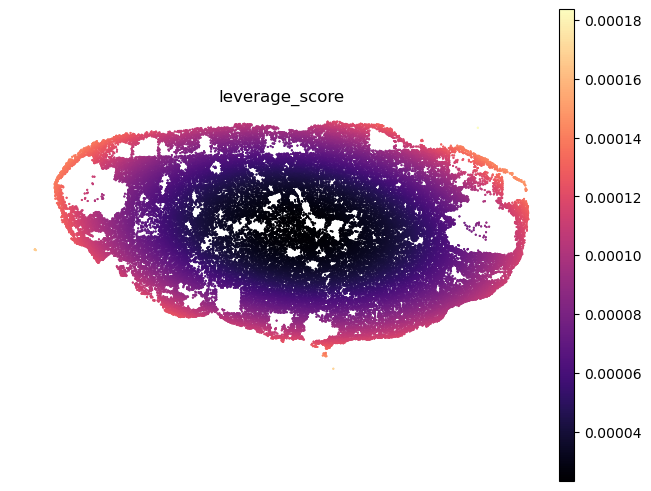

In [17]:
sq.pl.spatial_scatter(adata, color="leverage_score", size=1, cmap='magma',frameon=False,
        shape=None)

In [22]:
# Assume adata is your AnnData object with spatial coordinates
coordinates = adata.obsm['spatial']



# Add a constant to the independent variable matrix (to include an intercept in the regression)
X = sm.add_constant(coordinates)

# Create a dummy response variable (e.g., equal length zeros). This is needed to fit a model.
y = np.zeros(X.shape[0])

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Calculate the leverage scores (hat matrix diagonals)
leverage_scores = results.get_influence().hat_matrix_diag

# Add leverage scores to your AnnData object
adata.obs['leverage_score_sm'] = leverage_scores

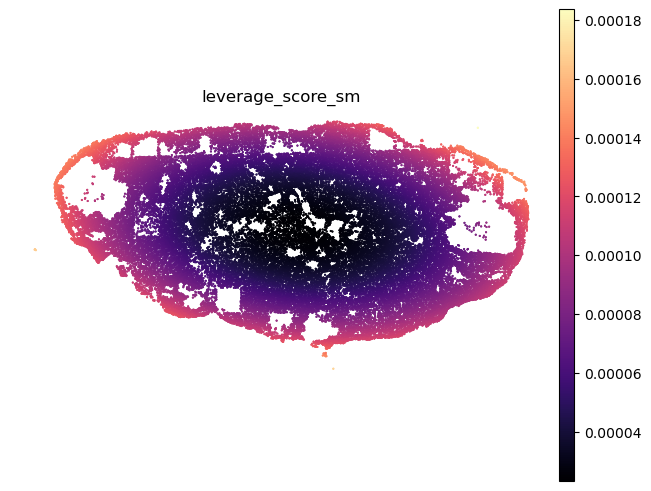

In [23]:
sq.pl.spatial_scatter(adata, color="leverage_score_sm", size=1, cmap='magma',frameon=False,
        shape=None)